In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F

torch.manual_seed(19)

In [3]:


class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        # print(np.max(cv2.resize(image.T, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)),image.T.shape, )
        label_temp = np.zeros((2,))
        label_temp[label] = 1
        return torch.tensor(image), torch.tensor(label_temp)

In [4]:
from torch.utils.data import DataLoader
training_data = NCarsImageDataset("./Datasety/train_EST")
test_data = NCarsImageDataset("./Datasety/test_EST")



In [5]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [6]:
from torch import nn

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return F.hardtanh(x)
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 80, start_factor=1.0, end_factor=0.01, total_iters=70):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2__128x128.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [8]:
# creating the model

model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], in_channels = 12).to("cuda")


In [9]:
img, label = next(iter(train_dataloader))

In [10]:
print(img.shape)

torch.Size([32, 12, 128, 128])


tensor([0., 1.], dtype=torch.float64)


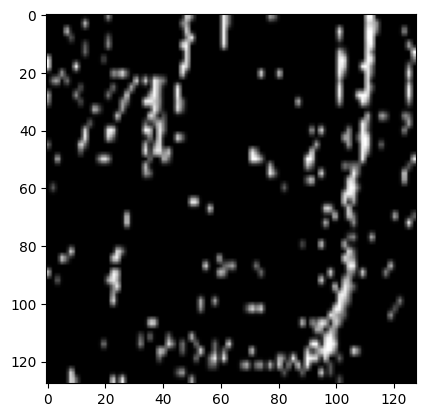

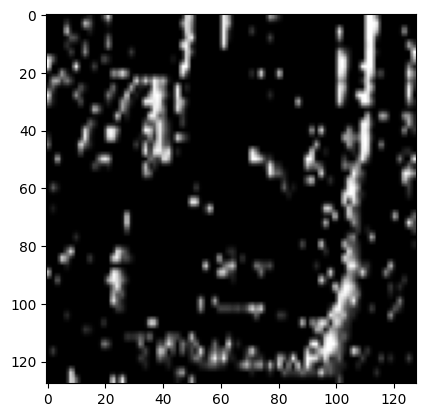

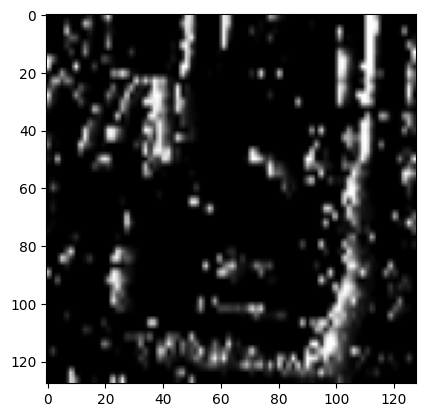

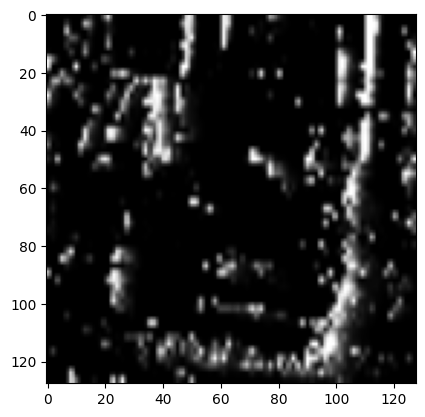

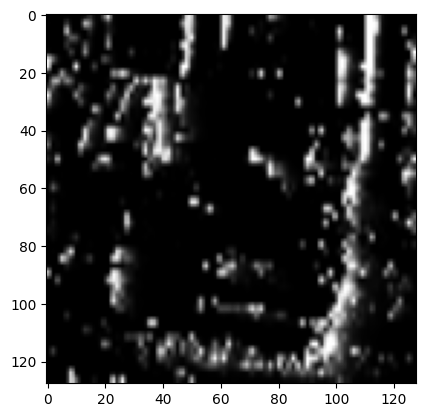

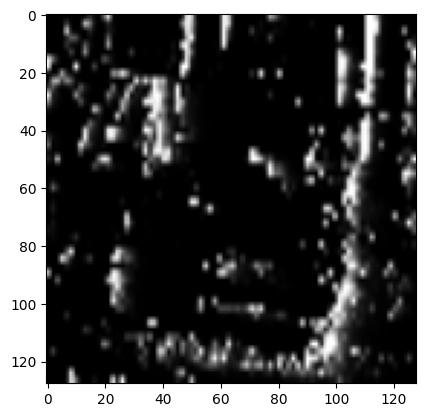

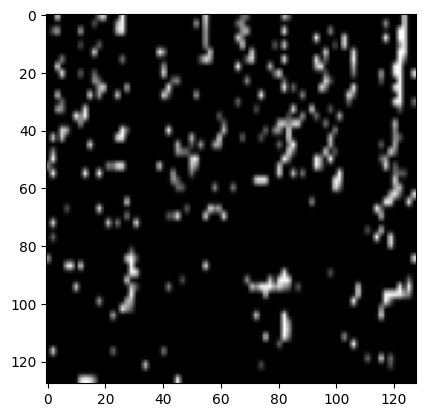

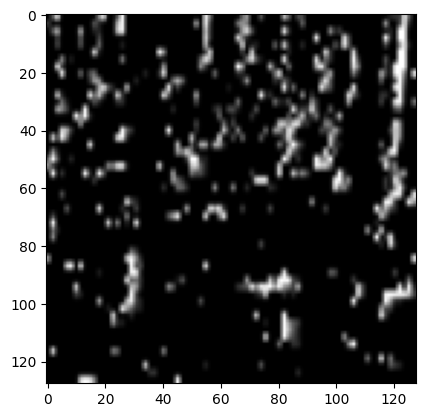

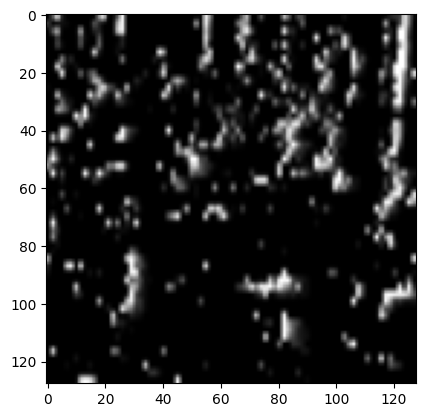

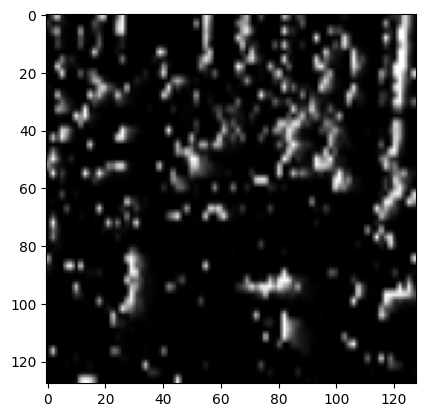

tensor(1.)


In [11]:
for j in range(1):
    print(label[j])
    for i in range(10):
        plt.imshow(img[j,i,:,:])
        plt.gray()
        
        plt.show()
print(torch.max(img))

In [12]:
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90) #, learning_rate=5e-4

100%|██████████| 482/482 [00:58<00:00,  8.20it/s]


Epoch [1/120], Step [482/482], Loss: 0.6881, Accuracy: 0.4907
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:56<00:00,  8.46it/s]


Epoch [2/120], Step [482/482], Loss: 0.6996, Accuracy: 0.4833
Accuracy of the network: 48.739398164284886 Loss: 0.6931478175088819%


100%|██████████| 482/482 [00:55<00:00,  8.65it/s]


Epoch [3/120], Step [482/482], Loss: 0.6989, Accuracy: 0.4842
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:55<00:00,  8.71it/s]


Epoch [4/120], Step [482/482], Loss: 0.6939, Accuracy: 0.4861
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:55<00:00,  8.74it/s]


Epoch [5/120], Step [482/482], Loss: 0.6958, Accuracy: 0.4842
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:55<00:00,  8.73it/s]


Epoch [6/120], Step [482/482], Loss: 0.7046, Accuracy: 0.4852
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:54<00:00,  8.78it/s]


Epoch [7/120], Step [482/482], Loss: 0.6947, Accuracy: 0.4855
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:54<00:00,  8.78it/s]


Epoch [8/120], Step [482/482], Loss: 0.6941, Accuracy: 0.4825
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:55<00:00,  8.72it/s]


Epoch [9/120], Step [482/482], Loss: 0.6948, Accuracy: 0.4877
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:56<00:00,  8.53it/s]


Epoch [10/120], Step [482/482], Loss: 0.6952, Accuracy: 0.4844
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:53<00:00,  9.06it/s]


Epoch [11/120], Step [482/482], Loss: 0.6944, Accuracy: 0.4881
Accuracy of the network: 48.925293365864995 Loss: 0.6914769466481687%


100%|██████████| 482/482 [00:52<00:00,  9.24it/s]


Epoch [12/120], Step [482/482], Loss: 0.6930, Accuracy: 0.4913
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:52<00:00,  9.23it/s]


Epoch [13/120], Step [482/482], Loss: 0.6909, Accuracy: 0.4846
Accuracy of the network: 48.925293365864995 Loss: 0.6931042649045753%


100%|██████████| 482/482 [00:52<00:00,  9.23it/s]


Epoch [14/120], Step [482/482], Loss: 0.6934, Accuracy: 0.4834
Accuracy of the network: 48.925293365864995 Loss: 0.7241791316124586%


100%|██████████| 482/482 [00:52<00:00,  9.23it/s]


Epoch [15/120], Step [482/482], Loss: 0.6947, Accuracy: 0.4881
Accuracy of the network: 39.10770303241548 Loss: 0.6960566622173919%


100%|██████████| 482/482 [00:52<00:00,  9.24it/s]


Epoch [16/120], Step [482/482], Loss: 0.6940, Accuracy: 0.4870
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:52<00:00,  9.24it/s]


Epoch [17/120], Step [482/482], Loss: 0.5142, Accuracy: 0.7395
Accuracy of the network: 76.1821772975485 Loss: 0.510802883197827%


100%|██████████| 482/482 [00:52<00:00,  9.23it/s]


Epoch [18/120], Step [482/482], Loss: 0.4146, Accuracy: 0.8276
Accuracy of the network: 75.77553154409202 Loss: 0.5142062987204378%


100%|██████████| 482/482 [00:52<00:00,  9.25it/s]


Epoch [19/120], Step [482/482], Loss: 0.3945, Accuracy: 0.8367
Accuracy of the network: 78.72661786917625 Loss: 0.4727670765831568%


100%|██████████| 482/482 [00:52<00:00,  9.25it/s]


Epoch [20/120], Step [482/482], Loss: 0.3734, Accuracy: 0.8500
Accuracy of the network: 79.42372487510166 Loss: 0.4629322918595878%


100%|██████████| 482/482 [00:52<00:00,  9.24it/s]


Epoch [21/120], Step [482/482], Loss: 0.3727, Accuracy: 0.8525
Accuracy of the network: 74.31160683164866 Loss: 0.5502751632472397%


100%|██████████| 482/482 [00:52<00:00,  9.24it/s]


Epoch [22/120], Step [482/482], Loss: 0.3627, Accuracy: 0.8597
Accuracy of the network: 76.00790054606715 Loss: 0.5251266961868811%


100%|██████████| 482/482 [00:52<00:00,  9.26it/s]


Epoch [23/120], Step [482/482], Loss: 0.3543, Accuracy: 0.8636
Accuracy of the network: 79.15650052283026 Loss: 0.4724639081932798%


100%|██████████| 482/482 [00:52<00:00,  9.23it/s]


Epoch [24/120], Step [482/482], Loss: 0.3551, Accuracy: 0.8612
Accuracy of the network: 80.03950273033577 Loss: 0.4532868071116479%


100%|██████████| 482/482 [00:52<00:00,  9.23it/s]


Epoch [25/120], Step [482/482], Loss: 0.3415, Accuracy: 0.8705
Accuracy of the network: 76.91413965377019 Loss: 0.5042777161726721%


100%|██████████| 482/482 [00:52<00:00,  9.23it/s]


Epoch [26/120], Step [482/482], Loss: 0.3322, Accuracy: 0.8747
Accuracy of the network: 76.80957360288137 Loss: 0.4983873264275519%


100%|██████████| 482/482 [00:52<00:00,  9.27it/s]


Epoch [27/120], Step [482/482], Loss: 0.3289, Accuracy: 0.8778
Accuracy of the network: 77.62286510979435 Loss: 0.4980150445686397%


100%|██████████| 482/482 [00:51<00:00,  9.28it/s]


Epoch [28/120], Step [482/482], Loss: 0.3273, Accuracy: 0.8797
Accuracy of the network: 78.87765772046009 Loss: 0.4789080319573002%


100%|██████████| 482/482 [00:52<00:00,  9.25it/s]


Epoch [29/120], Step [482/482], Loss: 0.3248, Accuracy: 0.8825
Accuracy of the network: 80.55071453468108 Loss: 0.44598147267524196%


100%|██████████| 482/482 [00:52<00:00,  9.25it/s]


Epoch [30/120], Step [482/482], Loss: 0.3126, Accuracy: 0.8887
Accuracy of the network: 80.34158243290345 Loss: 0.45287612196902804%


100%|██████████| 482/482 [00:52<00:00,  9.25it/s]


Epoch [31/120], Step [482/482], Loss: 0.3124, Accuracy: 0.8883
Accuracy of the network: 77.89008946206576 Loss: 0.4970037025368347%


100%|██████████| 482/482 [00:52<00:00,  9.25it/s]


Epoch [32/120], Step [482/482], Loss: 0.3059, Accuracy: 0.8922
Accuracy of the network: 82.8860230045312 Loss: 0.4114980145347163%


100%|██████████| 482/482 [00:52<00:00,  9.26it/s]


Epoch [33/120], Step [482/482], Loss: 0.3066, Accuracy: 0.8916
Accuracy of the network: 81.64284884396422 Loss: 0.42963579474328617%


100%|██████████| 482/482 [00:52<00:00,  9.25it/s]


Epoch [34/120], Step [482/482], Loss: 0.3053, Accuracy: 0.8929
Accuracy of the network: 82.36319275008714 Loss: 0.4210419834878808%


100%|██████████| 482/482 [00:52<00:00,  9.24it/s]


Epoch [35/120], Step [482/482], Loss: 0.2984, Accuracy: 0.8992
Accuracy of the network: 80.87603113744626 Loss: 0.4396880098989019%


100%|██████████| 482/482 [00:52<00:00,  9.24it/s]


Epoch [36/120], Step [482/482], Loss: 0.2937, Accuracy: 0.8994
Accuracy of the network: 81.66608574416173 Loss: 0.4291006333322773%


100%|██████████| 482/482 [00:52<00:00,  9.26it/s]


Epoch [37/120], Step [482/482], Loss: 0.2939, Accuracy: 0.8985
Accuracy of the network: 83.43209015917277 Loss: 0.3992615780865836%


100%|██████████| 482/482 [00:51<00:00,  9.37it/s]


Epoch [38/120], Step [482/482], Loss: 0.2929, Accuracy: 0.9011
Accuracy of the network: 82.18891599860578 Loss: 0.41991711975695034%


100%|██████████| 482/482 [00:50<00:00,  9.53it/s]


Epoch [39/120], Step [482/482], Loss: 0.2877, Accuracy: 0.9053
Accuracy of the network: 82.27024514929708 Loss: 0.41686297609681977%


100%|██████████| 482/482 [00:50<00:00,  9.52it/s]


Epoch [40/120], Step [482/482], Loss: 0.2885, Accuracy: 0.9023
Accuracy of the network: 80.03950273033577 Loss: 0.4584867733229492%


100%|██████████| 482/482 [00:50<00:00,  9.52it/s]


Epoch [41/120], Step [482/482], Loss: 0.2837, Accuracy: 0.9060
Accuracy of the network: 82.00302079702567 Loss: 0.42584035659146574%


100%|██████████| 482/482 [00:50<00:00,  9.51it/s]


Epoch [42/120], Step [482/482], Loss: 0.2848, Accuracy: 0.9044
Accuracy of the network: 83.67607761124665 Loss: 0.4027807821128448%


100%|██████████| 482/482 [00:50<00:00,  9.53it/s]


Epoch [43/120], Step [482/482], Loss: 0.2830, Accuracy: 0.9060
Accuracy of the network: 81.43371674218659 Loss: 0.42966038697714254%


100%|██████████| 482/482 [00:56<00:00,  8.58it/s]


Epoch [44/120], Step [482/482], Loss: 0.2769, Accuracy: 0.9101
Accuracy of the network: 81.88683629603811 Loss: 0.4353139383309836%


100%|██████████| 482/482 [00:56<00:00,  8.55it/s]


Epoch [45/120], Step [482/482], Loss: 0.2737, Accuracy: 0.9129
Accuracy of the network: 82.25862669919833 Loss: 0.42634027376494%


100%|██████████| 482/482 [00:54<00:00,  8.78it/s]


Epoch [46/120], Step [482/482], Loss: 0.2728, Accuracy: 0.9135
Accuracy of the network: 84.55907981875218 Loss: 0.38485871803804844%


100%|██████████| 482/482 [00:56<00:00,  8.59it/s]


Epoch [47/120], Step [482/482], Loss: 0.2716, Accuracy: 0.9136
Accuracy of the network: 83.71093296154292 Loss: 0.3934267109543861%


100%|██████████| 482/482 [00:55<00:00,  8.62it/s]


Epoch [48/120], Step [482/482], Loss: 0.2682, Accuracy: 0.9164
Accuracy of the network: 84.88439642151737 Loss: 0.3755817755669023%


100%|██████████| 482/482 [00:56<00:00,  8.51it/s]


Epoch [49/120], Step [482/482], Loss: 0.2631, Accuracy: 0.9212
Accuracy of the network: 83.38561635877774 Loss: 0.402346790557014%


100%|██████████| 482/482 [00:56<00:00,  8.60it/s]


Epoch [50/120], Step [482/482], Loss: 0.2590, Accuracy: 0.9205
Accuracy of the network: 84.24538166608575 Loss: 0.38662371604416007%


100%|██████████| 482/482 [00:55<00:00,  8.63it/s]


Epoch [51/120], Step [482/482], Loss: 0.2611, Accuracy: 0.9218
Accuracy of the network: 85.04705472289997 Loss: 0.3737804098643335%


100%|██████████| 482/482 [00:55<00:00,  8.63it/s]


Epoch [52/120], Step [482/482], Loss: 0.2585, Accuracy: 0.9221
Accuracy of the network: 84.39642151736959 Loss: 0.3847570256451249%


100%|██████████| 482/482 [00:55<00:00,  8.63it/s]


Epoch [53/120], Step [482/482], Loss: 0.2524, Accuracy: 0.9262
Accuracy of the network: 84.80306727082608 Loss: 0.37852607246446784%


100%|██████████| 482/482 [00:55<00:00,  8.61it/s]


Epoch [54/120], Step [482/482], Loss: 0.2559, Accuracy: 0.9232
Accuracy of the network: 84.03624956430812 Loss: 0.3896090183337825%


100%|██████████| 482/482 [00:55<00:00,  8.71it/s]


Epoch [55/120], Step [482/482], Loss: 0.2508, Accuracy: 0.9277
Accuracy of the network: 84.38480306727082 Loss: 0.3797874162631407%


100%|██████████| 482/482 [00:54<00:00,  8.79it/s]


Epoch [56/120], Step [482/482], Loss: 0.2456, Accuracy: 0.9306
Accuracy of the network: 85.1748576739863 Loss: 0.3703172135419562%


100%|██████████| 482/482 [00:55<00:00,  8.61it/s]


Epoch [57/120], Step [482/482], Loss: 0.2465, Accuracy: 0.9302
Accuracy of the network: 86.13918903218311 Loss: 0.35608475879665646%


100%|██████████| 482/482 [00:56<00:00,  8.59it/s]


Epoch [58/120], Step [482/482], Loss: 0.2430, Accuracy: 0.9328
Accuracy of the network: 83.30428720808644 Loss: 0.4043312110422269%


100%|██████████| 482/482 [00:56<00:00,  8.57it/s]


Epoch [59/120], Step [482/482], Loss: 0.2448, Accuracy: 0.9306
Accuracy of the network: 84.74497502033229 Loss: 0.3751193511552527%


100%|██████████| 482/482 [00:56<00:00,  8.56it/s]


Epoch [60/120], Step [482/482], Loss: 0.2394, Accuracy: 0.9341
Accuracy of the network: 85.84872777971418 Loss: 0.35964621930317364%


100%|██████████| 482/482 [00:56<00:00,  8.54it/s]


Epoch [61/120], Step [482/482], Loss: 0.2350, Accuracy: 0.9361
Accuracy of the network: 85.38398977576391 Loss: 0.3675913231301928%


100%|██████████| 482/482 [00:56<00:00,  8.51it/s]


Epoch [62/120], Step [482/482], Loss: 0.2363, Accuracy: 0.9337
Accuracy of the network: 84.55907981875218 Loss: 0.3743124490112177%


100%|██████████| 482/482 [00:56<00:00,  8.54it/s]


Epoch [63/120], Step [482/482], Loss: 0.2328, Accuracy: 0.9375
Accuracy of the network: 86.80144068781225 Loss: 0.35143530341107604%


100%|██████████| 482/482 [00:56<00:00,  8.53it/s]


Epoch [64/120], Step [482/482], Loss: 0.2297, Accuracy: 0.9389
Accuracy of the network: 85.81387242941791 Loss: 0.36033490460823014%


100%|██████████| 482/482 [00:56<00:00,  8.56it/s]


Epoch [65/120], Step [482/482], Loss: 0.2271, Accuracy: 0.9413
Accuracy of the network: 86.47612408504706 Loss: 0.34337900401712795%


100%|██████████| 482/482 [00:54<00:00,  8.77it/s]


Epoch [66/120], Step [482/482], Loss: 0.2311, Accuracy: 0.9398
Accuracy of the network: 86.96409898919484 Loss: 0.3408513100727783%


100%|██████████| 482/482 [00:56<00:00,  8.58it/s]


Epoch [67/120], Step [482/482], Loss: 0.2234, Accuracy: 0.9426
Accuracy of the network: 86.91762518879982 Loss: 0.33738212320662786%


100%|██████████| 482/482 [00:56<00:00,  8.59it/s]


Epoch [68/120], Step [482/482], Loss: 0.2194, Accuracy: 0.9462
Accuracy of the network: 86.63878238642965 Loss: 0.3514752591852805%


100%|██████████| 482/482 [00:56<00:00,  8.54it/s]


Epoch [69/120], Step [482/482], Loss: 0.2177, Accuracy: 0.9475
Accuracy of the network: 87.63796909492274 Loss: 0.3320118458629984%


100%|██████████| 482/482 [00:56<00:00,  8.55it/s]


Epoch [70/120], Step [482/482], Loss: 0.2216, Accuracy: 0.9446
Accuracy of the network: 87.55663994423143 Loss: 0.3332477801351299%


100%|██████████| 482/482 [00:56<00:00,  8.57it/s]


Epoch [71/120], Step [482/482], Loss: 0.2172, Accuracy: 0.9481
Accuracy of the network: 87.1383757406762 Loss: 0.3328754434909076%


100%|██████████| 482/482 [00:56<00:00,  8.53it/s]


Epoch [72/120], Step [482/482], Loss: 0.2167, Accuracy: 0.9476
Accuracy of the network: 86.90600673870105 Loss: 0.34122287036096294%


100%|██████████| 482/482 [00:56<00:00,  8.54it/s]


Epoch [73/120], Step [482/482], Loss: 0.2122, Accuracy: 0.9503
Accuracy of the network: 87.23132334146625 Loss: 0.33848808428833477%


100%|██████████| 482/482 [00:56<00:00,  8.51it/s]


Epoch [74/120], Step [482/482], Loss: 0.2108, Accuracy: 0.9502
Accuracy of the network: 85.48855582665273 Loss: 0.3650768907207539%


100%|██████████| 482/482 [00:56<00:00,  8.46it/s]


Epoch [75/120], Step [482/482], Loss: 0.2115, Accuracy: 0.9521
Accuracy of the network: 87.9168118972929 Loss: 0.3253390624509868%


100%|██████████| 482/482 [00:55<00:00,  8.64it/s]


Epoch [76/120], Step [482/482], Loss: 0.2085, Accuracy: 0.9523
Accuracy of the network: 87.95166724758917 Loss: 0.3264701995707799%


100%|██████████| 482/482 [00:56<00:00,  8.58it/s]


Epoch [77/120], Step [482/482], Loss: 0.2058, Accuracy: 0.9537
Accuracy of the network: 88.55582665272452 Loss: 0.31495413616244233%


100%|██████████| 482/482 [00:56<00:00,  8.46it/s]


Epoch [78/120], Step [482/482], Loss: 0.2026, Accuracy: 0.9564
Accuracy of the network: 87.90519344719415 Loss: 0.3241471660403071%


100%|██████████| 482/482 [00:54<00:00,  8.77it/s]


Epoch [79/120], Step [482/482], Loss: 0.1987, Accuracy: 0.9586
Accuracy of the network: 87.90519344719415 Loss: 0.32572826106087427%


100%|██████████| 482/482 [00:52<00:00,  9.10it/s]


Epoch [80/120], Step [482/482], Loss: 0.2004, Accuracy: 0.9579
Accuracy of the network: 88.31183920065064 Loss: 0.3212995030622943%


100%|██████████| 482/482 [00:54<00:00,  8.86it/s]


Epoch [81/120], Step [482/482], Loss: 0.1994, Accuracy: 0.9584
Accuracy of the network: 87.42883699314511 Loss: 0.33426411089843977%


100%|██████████| 482/482 [00:52<00:00,  9.10it/s]


Epoch [82/120], Step [482/482], Loss: 0.1972, Accuracy: 0.9594
Accuracy of the network: 87.68444289531776 Loss: 0.3292651422958835%


100%|██████████| 482/482 [00:53<00:00,  9.07it/s]


Epoch [83/120], Step [482/482], Loss: 0.1948, Accuracy: 0.9612
Accuracy of the network: 87.84710119670036 Loss: 0.33049765893960975%


100%|██████████| 482/482 [00:55<00:00,  8.75it/s]


Epoch [84/120], Step [482/482], Loss: 0.1916, Accuracy: 0.9629
Accuracy of the network: 87.27779714186127 Loss: 0.3347948512623301%


100%|██████████| 482/482 [00:55<00:00,  8.67it/s]


Epoch [85/120], Step [482/482], Loss: 0.1899, Accuracy: 0.9645
Accuracy of the network: 88.48611595213198 Loss: 0.31779292763165823%


100%|██████████| 482/482 [00:54<00:00,  8.78it/s]


Epoch [86/120], Step [482/482], Loss: 0.1891, Accuracy: 0.9654
Accuracy of the network: 88.88114325548972 Loss: 0.3101595326648769%


100%|██████████| 482/482 [00:56<00:00,  8.54it/s]


Epoch [87/120], Step [482/482], Loss: 0.1893, Accuracy: 0.9649
Accuracy of the network: 88.92761705588474 Loss: 0.31236562271322016%


100%|██████████| 482/482 [00:56<00:00,  8.59it/s]


Epoch [88/120], Step [482/482], Loss: 0.1850, Accuracy: 0.9678
Accuracy of the network: 88.98570930637852 Loss: 0.3126004313336872%


100%|██████████| 482/482 [00:56<00:00,  8.57it/s]


Epoch [89/120], Step [482/482], Loss: 0.1868, Accuracy: 0.9664
Accuracy of the network: 89.05542000697108 Loss: 0.30590842498057835%


100%|██████████| 482/482 [00:56<00:00,  8.57it/s]


Epoch [90/120], Step [482/482], Loss: 0.1845, Accuracy: 0.9668
Accuracy of the network: 89.33426280934124 Loss: 0.3026548576399296%


100%|██████████| 482/482 [00:56<00:00,  8.56it/s]


Epoch [91/120], Step [482/482], Loss: 0.1829, Accuracy: 0.9678
Accuracy of the network: 88.67201115371209 Loss: 0.3138404413780758%


100%|██████████| 482/482 [00:56<00:00,  8.54it/s]


Epoch [92/120], Step [482/482], Loss: 0.1803, Accuracy: 0.9689
Accuracy of the network: 89.68281631230394 Loss: 0.303125719432494%


100%|██████████| 482/482 [00:56<00:00,  8.59it/s]


Epoch [93/120], Step [482/482], Loss: 0.1776, Accuracy: 0.9722
Accuracy of the network: 89.05542000697108 Loss: 0.3053107726972786%


100%|██████████| 482/482 [00:56<00:00,  8.57it/s]


Epoch [94/120], Step [482/482], Loss: 0.1775, Accuracy: 0.9724
Accuracy of the network: 89.78738236319275 Loss: 0.2974860606140364%


100%|██████████| 482/482 [00:56<00:00,  8.57it/s]


Epoch [95/120], Step [482/482], Loss: 0.1740, Accuracy: 0.9742
Accuracy of the network: 88.88114325548972 Loss: 0.31230279642631575%


100%|██████████| 482/482 [00:56<00:00,  8.55it/s]


Epoch [96/120], Step [482/482], Loss: 0.1745, Accuracy: 0.9744
Accuracy of the network: 89.55501336121762 Loss: 0.302545483559924%


100%|██████████| 482/482 [00:56<00:00,  8.52it/s]


Epoch [97/120], Step [482/482], Loss: 0.1738, Accuracy: 0.9747
Accuracy of the network: 89.1018938073661 Loss: 0.3035974973971959%


100%|██████████| 482/482 [00:56<00:00,  8.48it/s]


Epoch [98/120], Step [482/482], Loss: 0.1715, Accuracy: 0.9762
Accuracy of the network: 89.46206576042756 Loss: 0.3081495334778577%


100%|██████████| 482/482 [00:58<00:00,  8.29it/s]


Epoch [99/120], Step [482/482], Loss: 0.1705, Accuracy: 0.9762
Accuracy of the network: 89.19484140815615 Loss: 0.3054224198967994%


100%|██████████| 482/482 [00:55<00:00,  8.63it/s]


Epoch [100/120], Step [482/482], Loss: 0.1695, Accuracy: 0.9777
Accuracy of the network: 89.24131520855119 Loss: 0.3044336683577321%


100%|██████████| 482/482 [00:54<00:00,  8.84it/s]


Epoch [101/120], Step [482/482], Loss: 0.1669, Accuracy: 0.9798
Accuracy of the network: 89.74090856279773 Loss: 0.3009196813443336%


100%|██████████| 482/482 [00:58<00:00,  8.27it/s]


Epoch [102/120], Step [482/482], Loss: 0.1674, Accuracy: 0.9783
Accuracy of the network: 89.775763913094 Loss: 0.30003865943965413%


100%|██████████| 482/482 [00:56<00:00,  8.49it/s]


Epoch [103/120], Step [482/482], Loss: 0.1632, Accuracy: 0.9811
Accuracy of the network: 89.55501336121762 Loss: 0.3018271818923241%


100%|██████████| 482/482 [00:55<00:00,  8.68it/s]


Epoch [104/120], Step [482/482], Loss: 0.1655, Accuracy: 0.9802
Accuracy of the network: 89.50853956082258 Loss: 0.30222331175795275%


100%|██████████| 482/482 [00:55<00:00,  8.66it/s]


Epoch [105/120], Step [482/482], Loss: 0.1618, Accuracy: 0.9826
Accuracy of the network: 89.29940745904496 Loss: 0.30329189646199733%


100%|██████████| 482/482 [00:56<00:00,  8.54it/s]


Epoch [106/120], Step [482/482], Loss: 0.1606, Accuracy: 0.9830
Accuracy of the network: 89.79900081329151 Loss: 0.294566230647626%


100%|██████████| 482/482 [00:56<00:00,  8.54it/s]


Epoch [107/120], Step [482/482], Loss: 0.1602, Accuracy: 0.9826
Accuracy of the network: 89.90356686418032 Loss: 0.29457309437728724%


100%|██████████| 482/482 [00:56<00:00,  8.54it/s]


Epoch [108/120], Step [482/482], Loss: 0.1573, Accuracy: 0.9850
Accuracy of the network: 90.07784361566168 Loss: 0.29423801384893933%


100%|██████████| 482/482 [00:56<00:00,  8.58it/s]


Epoch [109/120], Step [482/482], Loss: 0.1578, Accuracy: 0.9839
Accuracy of the network: 89.81061926339027 Loss: 0.2975626199551231%


100%|██████████| 482/482 [00:55<00:00,  8.66it/s]


Epoch [110/120], Step [482/482], Loss: 0.1584, Accuracy: 0.9842
Accuracy of the network: 89.56663181131637 Loss: 0.29846205952885424%


100%|██████████| 482/482 [00:55<00:00,  8.68it/s]


Epoch [111/120], Step [482/482], Loss: 0.1556, Accuracy: 0.9856
Accuracy of the network: 90.2288834669455 Loss: 0.29079600875040856%


100%|██████████| 482/482 [00:55<00:00,  8.68it/s]


Epoch [112/120], Step [482/482], Loss: 0.1553, Accuracy: 0.9859
Accuracy of the network: 89.33426280934124 Loss: 0.30034234377531316%


100%|██████████| 482/482 [00:55<00:00,  8.64it/s]


Epoch [113/120], Step [482/482], Loss: 0.1542, Accuracy: 0.9877
Accuracy of the network: 90.0429882653654 Loss: 0.2938993887276454%


100%|██████████| 482/482 [00:55<00:00,  8.64it/s]


Epoch [114/120], Step [482/482], Loss: 0.1529, Accuracy: 0.9878
Accuracy of the network: 90.1243174160567 Loss: 0.29506329211603755%


100%|██████████| 482/482 [00:55<00:00,  8.64it/s]


Epoch [115/120], Step [482/482], Loss: 0.1518, Accuracy: 0.9884
Accuracy of the network: 90.43801556872313 Loss: 0.2886455721017596%


100%|██████████| 482/482 [00:55<00:00,  8.65it/s]


Epoch [116/120], Step [482/482], Loss: 0.1533, Accuracy: 0.9874
Accuracy of the network: 89.65957941210642 Loss: 0.3024759355198495%


100%|██████████| 482/482 [00:55<00:00,  8.62it/s]


Epoch [117/120], Step [482/482], Loss: 0.1507, Accuracy: 0.9890
Accuracy of the network: 89.56663181131637 Loss: 0.300312355991633%


100%|██████████| 482/482 [00:55<00:00,  8.64it/s]


Epoch [118/120], Step [482/482], Loss: 0.1508, Accuracy: 0.9891
Accuracy of the network: 89.91518531427907 Loss: 0.2947881633907446%


100%|██████████| 482/482 [00:55<00:00,  8.69it/s]


Epoch [119/120], Step [482/482], Loss: 0.1499, Accuracy: 0.9893
Accuracy of the network: 89.97327756477286 Loss: 0.29521732071075296%


100%|██████████| 482/482 [00:55<00:00,  8.66it/s]


Epoch [120/120], Step [482/482], Loss: 0.1499, Accuracy: 0.9892
Accuracy of the network: 90.01975136516789 Loss: 0.30038489899892346%


In [13]:
torch.save(model_resnet, "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2_128x128.pt")

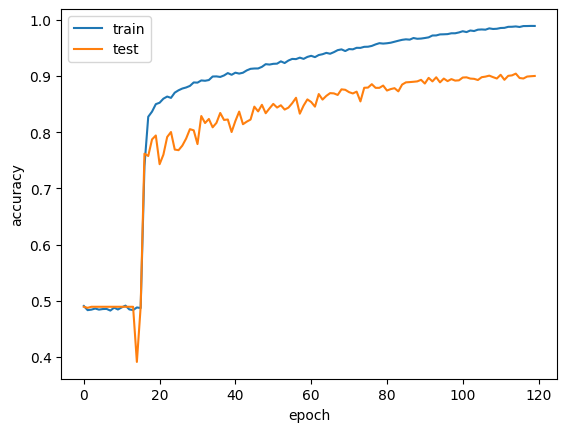

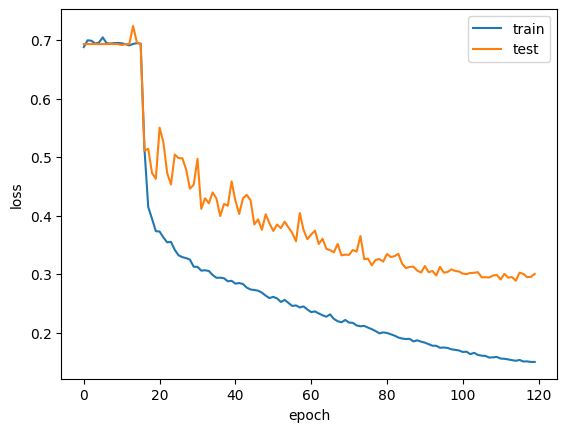

In [14]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [15]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2_128x128.csv')

In [16]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.490663,0.489253,0.688078,0.693147
1,0.483271,0.487394,0.699609,0.693148
2,0.484178,0.489253,0.698877,0.693147
3,0.486124,0.489253,0.693899,0.693147
4,0.484178,0.489253,0.695848,0.693147
